# Error al alinear ya que se intenta alinear con parejas de cualquier atomo y en realidad es solo tomando Calfalfas y los elementos del clique para obtener el SO y su RMSD

Se corrige al obtener la mejor pareja de cliques que maximiza el SO con las parejas de residuos agarradas, se genera una nueva matriz de rotacion con las parejas anteriores y se generan nuevas parejas donde se ordena nuevamente por distancia la mejor pareja, obteniendo el alineamiento final.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
sys.path.append('../math_tricks/')
import funciones_CLICK as fc
from scipy.spatial.distance import pdist, squareform
import multiprocessing

%matplotlib inline

In [29]:
rmsd = pd.read_pickle("../df_alineados.pkl")
rmsd

,distancia,candigatos,cand_1,cand2
0,0.3368,"(485, 796)",485,796
1,0.5361,"(136, 279)",136,279
2,0.9679,"(251, 710)",251,710
3,1.0505,"(342, 300)",342,300
4,1.1205,"(197, 834)",197,834
5,1.3781,"(121, 243)",121,243
6,1.4080,"(180, 847)",180,847
7,1.5792,"(476, 377)",476,377
8,1.6667,"(27, 2)",27,2
9,1.6835,"(383, 605)",383,605


In [2]:
df_atoms1 = pd.read_pickle('../clique1_df_atributos.pkl')
df_atoms2 = pd.read_pickle('../clique2_df_atributos.pkl')

rmsd = pd.read_pickle("../df_alineados.pkl")
parejas_clique = pd.read_pickle('../parejas.pkl')
parejas_clique = parejas_clique.astype(int)

In [13]:
parejas_clique = [tuple(i) for i in parejas_clique.values]

vecs1 = np.array([vecs for vecs in df_atoms1.vector.values])
vecs2 = np.array([vecs for vecs in df_atoms2.vector.values])

#baricentro
bari_1 = vecs1.mean(0)
bari_2 = vecs2.mean(0)

#vectores centricos
vecs_center_1 = vecs1 - bari_1
vecs_center_2 = vecs2 - bari_2

parejas = rmsd.candigatos.values
parejas = list(parejas)
for i in parejas_clique:
    parejas.append(i)
    
    
def R_ij(i,j):
    valor = sum([vecs_center_1[pos_res[0] - 1, i] * vecs_center_2[pos_res[1] - 1, j] for pos_res in parejas])
    return valor

temp = pd.DataFrame(parejas)[1].values

def matrix_R():
    
    """cliques a comparar: i,j
    desde aqui se itera sobre cada i y hay que variar los vectores
    coordenada
    Regresa la matriz gigante (matriz simetrica del articulo)"""
    # primer renglon
    R11R22R33 = (R_ij(0, 0) + R_ij(1, 1) + R_ij(2, 2))
    R23_R32 = (R_ij(1, 2) - R_ij(2, 1))
    R31_R13 = (R_ij(2, 0) - R_ij(0, 2))
    R12_R21 = (R_ij(0, 1) - R_ij(1, 0))
    # segundo renglon
    R11_R22_R33 = (R_ij(0, 0) - R_ij(1, 1) - R_ij(2, 2))
    R12R21 = (R_ij(0, 1) + R_ij(1, 0))
    R13R31 = (R_ij(0, 2) + R_ij(2, 0))
    # tercer renglon
    _R11R22_R33 = (-R_ij(0, 0) + R_ij(1, 1) - R_ij(2, 2))
    R23R32 = (R_ij(1, 2) + R_ij(2, 1))
    # cuarto renglon
    _R11_R22R33 = (-R_ij(0, 0) - R_ij(1, 1) + R_ij(2, 2))

    matriz_R = [
        [R11R22R33, R23_R32, R31_R13, R12_R21],
        [R23_R32, R11_R22_R33, R12R21, R13R31],
        [R31_R13, R12R21, _R11R22_R33, R23R32],
        [R12_R21, R13R31, R23R32, _R11_R22R33]
    ]
    return (matriz_R)

def rotation_matrix(matriz_R):
    """utilizando la funcion giant_matrix, fijando los valores de i,j
    se calcula la matriz de rotacion con los eigenvectores y eigenvalores
    arroja una matriz de rotacion que depende de la matriz gigante
    """
    eignvalues, eigenvectors = np.linalg.eig(matriz_R)
    q = eigenvectors[:, np.argmax(eignvalues)]
    q0, q1, q2, q3 = q[0], q[1], q[2], q[3]
    # matriz de rotacion con eigenvectores
    matriz_rotacion = np.array([
        [(q0 ** 2 + q1 ** 2 - q2 ** 2 - q3 ** 2), 2 * (q1 * q2 - q0 * q3), 2 * (q1 * q3 + q0 * q2)],
        [2 * (q1 * q2 + q0 * q3), (q0 ** 2 - q1 ** 2 + q2 ** 2 - q3 ** 2), 2 * (q2 * q3 - q0 * q1)],
        [2 * (q1 * q3 - q0 * q2), 2 * (q2 * q3 + q0 * q1), (q0 ** 2 - q1 ** 2 - q2 ** 2 + q3 ** 2)]
    ], dtype=np.float64)
    return (matriz_rotacion)

def rotation_vectors(vector_gorro, matriz_rotacion):
    """obtencion de vector rotado,
    utilizando la matriz de rotacion
    y los vectores gorro a rotar y trasladar"""

    coord_rotado = [np.matmul(
        matriz_rotacion, i.reshape(3, 1)).T[0] for i in vector_gorro]
    return (coord_rotado)

matriz_R = matrix_R()
matriz_rotacion = rotation_matrix(matriz_R)
vector_rotado = rotation_vectors(vecs_center_1, matriz_rotacion)
vector_rotado_trasladado_a_clique2 = vector_rotado + np.array(bari_2)
protein_trasladado_rotado = vector_rotado_trasladado_a_clique2
protein_to_compare = vecs2

protein_trasladado_rotado

In [14]:
import read_pdb_tools as rpt
file1 = '../1xxa_clean.pdb'
pdb1 = rpt.PdbStruct(file1)
pdb1.AddPdbData("%s" % file1)
pdb1.GetNeighbors()
pdb11 = pdb1.GetResChain()

In [15]:
new_df_atom1 = pd.concat([df_atoms1, pd.DataFrame(protein_trasladado_rotado, columns=['x', 'y', 'z'])], 1)
new_df_atom1['new_vector'] = [
    [new_df_atom1.iloc[i]['x'], new_df_atom1.iloc[i]['y'], new_df_atom1.iloc[i]['z']] for i in range(new_df_atom1.shape[0])]


for i in pdb11:
    mask = np.where(i.resi == new_df_atom1.residue_number, True, False)
    for j in new_df_atom1[mask].atom_name:
        mask_2 = np.where(new_df_atom1[mask].atom_name == j, True, False)
        i.GetAtom(j).UpDateValue('coord', new_df_atom1[mask][mask_2].new_vector.values[0])

pdb1.pdbdata = pdb11
pdb1.WriteToFile(file_out_name='1xxaclean_a_1tig')

In [16]:
atoms1 = df_atoms1.atom_number.values
atoms2 = df_atoms2.atom_number.values

residuos_match = []
for residuo_not_in_clique, res_1 in zip(protein_trasladado_rotado, atoms1):
    for residuo, res_2 in zip(protein_to_compare, atoms2):
        distancia = pdist(np.array([residuo_not_in_clique, residuo]), metric='euclidean').item()
        if distancia < 3.5:
            residuos_match.append([distancia, (res_1, res_2)])

In [17]:
number_of_residues = df_atoms1.shape[0]
df = pd.DataFrame(residuos_match, columns=['distancia', 'candigatos'])
df = df.sort_values('distancia')
df['cand1'] = df.candigatos.str[0]
df['cand2'] = df.candigatos.str[1]

c1 = []
c2 = []
cand_n = []
for i in df.values:
    if (i[2] in c1) or (i[3] in c2):
        continue
    else:
        c1.append(i[2])
        c2.append(i[3])
        cand_n.append(i)

so_temp = len(cand_n) / number_of_residues

In [18]:
so_temp

0.8082706766917294

In [19]:
parejas = pd.DataFrame(cand_n, columns=['distancia', 'candigatos', 'cand_1', 'cand2']).candigatos.values  

def R_ij(i,j):
    valor = sum([vecs_center_1[pos_res[0] - 1, i] * vecs_center_2[pos_res[1] - 1, j] for pos_res in parejas])
    return valor

In [20]:
matriz_R = matrix_R()
matriz_rotacion = rotation_matrix(matriz_R)
vector_rotado = rotation_vectors(vecs_center_1, matriz_rotacion)
vector_rotado_trasladado_a_clique2 = vector_rotado + np.array(bari_2)
protein_trasladado_rotado = vector_rotado_trasladado_a_clique2
protein_to_compare = vecs2

In [21]:
protein_trasladado_rotado

array([[13.36862555,  0.26746299, 27.0374745 ],
       [12.75355211,  1.56645933, 26.82490415],
       [13.34890799,  2.16341522, 25.5531978 ],
       ...,
       [10.07241386,  1.71333738, 16.40186531],
       [11.43656032,  3.69132737, 16.29144311],
       [11.28959804,  2.31675775, 16.12952815]])

In [22]:
# def rmsd_between_cliques(clique_trasladado_rotado, atom_to_compare):
#     """Calculo de rmsd entre cliques tomando el atomo rotado y trasladado
#     y el atomo a comparar, por el momento solo imprime el resultado"""
#     # primer RMSD entre atomos
#     p12 = np.sum((np.array(
#         atom_to_compare, dtype=np.float64) - clique_trasladado_rotado) ** 2, 1)
#     rmsd_i = lambda i: np.sqrt(i) / 3
#     rmsd_final = rmsd_i(p12).mean()

#     return (rmsd_final)

In [23]:
# rmsd_between_cliques(protein_trasladado_rotado,vecs2[temp,:])

In [24]:
import read_pdb_tools as rpt
file1 = '../1xxa_clean.pdb'
pdb1 = rpt.PdbStruct(file1)
pdb1.AddPdbData("%s" % file1)
pdb1.GetNeighbors()
pdb11 = pdb1.GetResChain()

In [25]:
new_df_atom1 = pd.concat([df_atoms1, pd.DataFrame(protein_trasladado_rotado, columns=['x', 'y', 'z'])], 1)
new_df_atom1['new_vector'] = [
    [new_df_atom1.iloc[i]['x'], new_df_atom1.iloc[i]['y'], new_df_atom1.iloc[i]['z']] for i in range(new_df_atom1.shape[0])]


for i in pdb11:
    mask = np.where(i.resi == new_df_atom1.residue_number, True, False)
    for j in new_df_atom1[mask].atom_name:
        mask_2 = np.where(new_df_atom1[mask].atom_name == j, True, False)
        i.GetAtom(j).UpDateValue('coord', new_df_atom1[mask][mask_2].new_vector.values[0])

pdb1.pdbdata = pdb11
pdb1.WriteToFile(file_out_name='1xxa_clean2')

In [79]:
pd.DataFrame(parejas,columns=['parejas']).head()

NameError: name 'parejas' is not defined

# OTRA VES FILTRO DISTANCIA MINIMA CREO VUELA DEMASIADAS COSAS

In [80]:
a = pd.read_pickle('../rmsd_3.pkl')

In [81]:
b = pd.read_pickle('../dist_3.pkl')

In [82]:
a = a[['rmsd','candidatos']]

In [83]:
a[0] = a.candidatos.str[0]
a[1] = a.candidatos.str[1]


In [84]:
b.columns = [0,1,'dist']

In [85]:
df = a.merge(b, on = [0,1])

In [86]:
df['cand'] = np.where(df.rmsd <= 0.15,1,0)

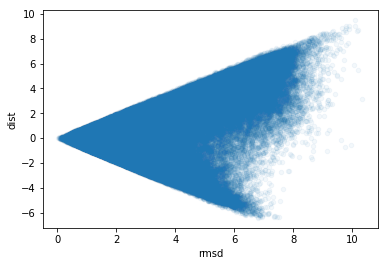

In [87]:
df.sample(frac=0.1).plot.scatter(x='rmsd',y='dist', alpha=0.05)

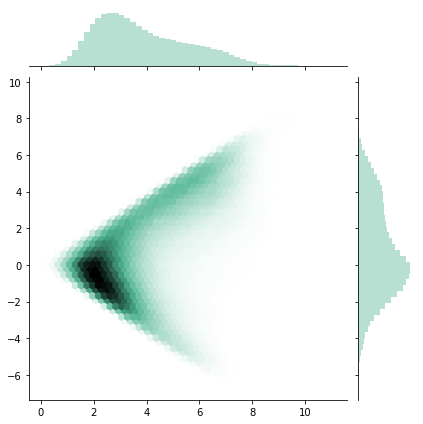

In [57]:
import seaborn as sns
sns.jointplot(df.rmsd.values, df.dist.values, kind="hex", color="#4CB391")

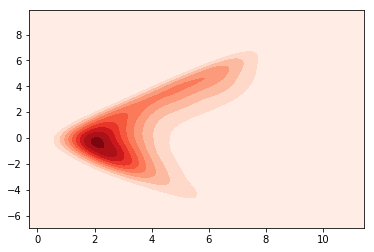

In [63]:
algo = df.sample(frac=0.0.5)

sns.kdeplot(algo.rmsd.values, algo.dist.values, cmap="Reds", shade=True, bw=.15)

In [88]:
df.groupby('cand').dist.describe().T

cand,0,1
count,1705504.0000,304.0000
mean,0.8703,-0.0062
std,2.5190,0.0507
min,-6.5670,-0.1313
25%,-0.9744,-0.0421
50%,0.5735,-0.0060
75%,2.7954,0.0263
max,9.4832,0.1388


In [64]:
a = pd.read_pickle('../rmsd_4.pkl')

In [65]:
b = pd.read_pickle('../dist_4.pkl')

In [66]:
a = a[['rmsd','candidatos']]

In [67]:
a[0] = a.candidatos.str[0]
a[1] = a.candidatos.str[1]


In [68]:
b.columns = [0,1,'dist']

In [69]:
df = a.merge(b, on = [0,1])

In [89]:
df['cand'] = np.where(df.rmsd <= 0.30,1,0)

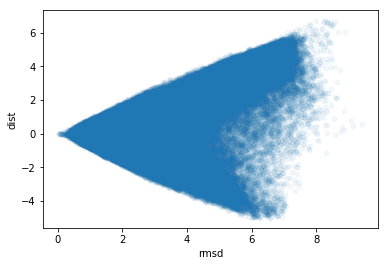

In [75]:
df.plot.scatter(x='rmsd',y='dist', alpha=0.05)

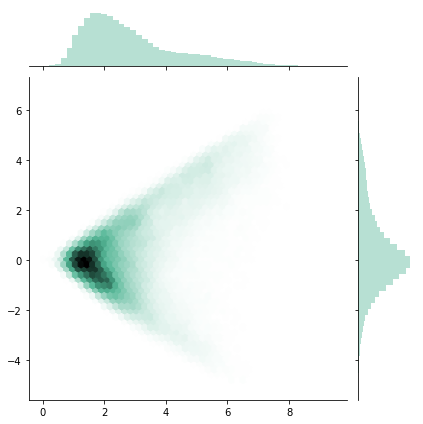

In [76]:
sns.jointplot(df.rmsd.values, df.dist.values, kind="hex", color="#4CB391")

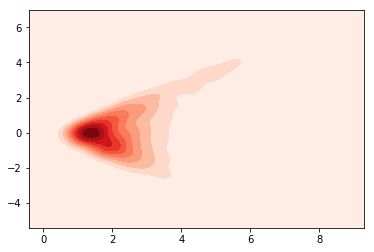

In [77]:
algo = df.sample(frac=0.05)
sns.kdeplot(algo.rmsd.values, algo.dist.values, cmap="Reds", shade=True, bw=.15)

In [90]:
df.groupby('cand').dist.describe().T

cand,0,1
count,1704117.0000,1691.0000
mean,0.8710,-0.0027
std,2.5199,0.1005
min,-6.5670,-0.2765
25%,-0.9757,-0.0688
50%,0.5763,-0.0039
75%,2.7974,0.0618
max,9.4832,0.2791


In [91]:
a = pd.read_pickle('../rmsd_5.pkl')

In [92]:
b = pd.read_pickle('../dist_5.pkl')

In [93]:
a = a[['rmsd','candidatos']]

In [94]:
a[0] = a.candidatos.str[0]
a[1] = a.candidatos.str[1]


In [95]:
b.columns = [0,1,'dist']

In [96]:
df = a.merge(b, on = [0,1])

In [97]:
df['cand'] = np.where(df.rmsd <= 0.60,1,0)

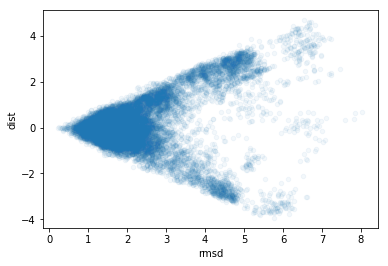

In [98]:
df.plot.scatter(x='rmsd',y='dist', alpha=0.05)

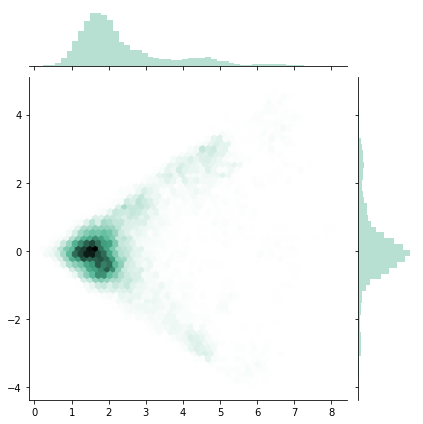

In [99]:
sns.jointplot(df.rmsd.values, df.dist.values, kind="hex", color="#4CB391")

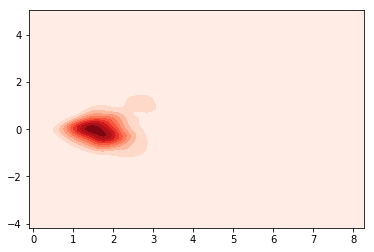

In [100]:
algo = df.sample(frac=0.05)
sns.kdeplot(algo.rmsd.values, algo.dist.values, cmap="Reds", shade=True, bw=.15)

In [101]:
df.groupby('cand').dist.describe().T

cand,0,1
count,17039.0000,48.0000
mean,0.1224,-0.0147
std,1.1601,0.1145
min,-3.9313,-0.3266
25%,-0.4492,-0.0482
50%,-0.0096,-0.0200
75%,0.5279,0.0178
max,4.6809,0.2372


In [102]:
a = pd.read_pickle('../rmsd_6.pkl')

In [103]:
b = pd.read_pickle('../dist_6.pkl')

In [104]:
a = a[['rmsd','candidatos']]

In [105]:
a[0] = a.candidatos.str[0]
a[1] = a.candidatos.str[1]


In [106]:
b.columns = [0,1,'dist']

In [107]:
df = a.merge(b, on = [0,1])

In [108]:
df['cand'] = np.where(df.rmsd <= 0.90,1,0)

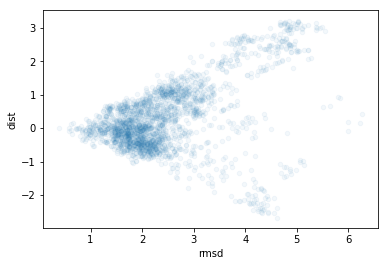

In [109]:
df.plot.scatter(x='rmsd',y='dist', alpha=0.05)

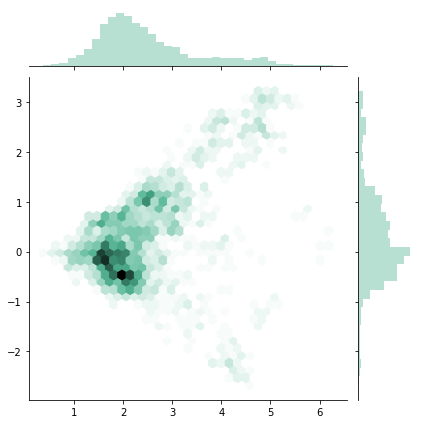

In [110]:
sns.jointplot(df.rmsd.values, df.dist.values, kind="hex", color="#4CB391")

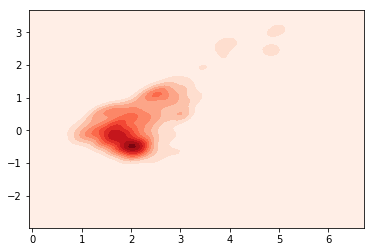

In [113]:
algo = df.sample(frac=0.5)
sns.kdeplot(algo.rmsd.values, algo.dist.values, cmap="Reds", shade=True, bw=.15)

In [114]:
df.groupby('cand').dist.describe().T

cand,0,1
count,2239.0000,23.0000
mean,0.2954,-0.0852
std,0.9926,0.1460
min,-2.6777,-0.3929
25%,-0.3478,-0.1496
50%,0.1221,-0.0535
75%,0.8089,-0.0068
max,3.2165,0.1604


In [115]:
a = pd.read_pickle('../rmsd_7.pkl')

In [116]:
b = pd.read_pickle('../dist_7.pkl')

In [117]:
a = a[['rmsd','candidatos']]

In [118]:
a[0] = a.candidatos.str[0]
a[1] = a.candidatos.str[1]


In [119]:
b.columns = [0,1,'dist']

In [126]:
df = a.merge(b, on = [0,1])

In [127]:
df['cand'] = np.where(df.rmsd <= 1.50,1,0)

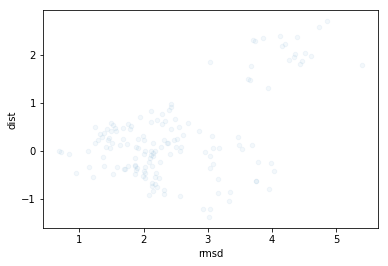

In [128]:
df.plot.scatter(x='rmsd',y='dist', alpha=0.05)

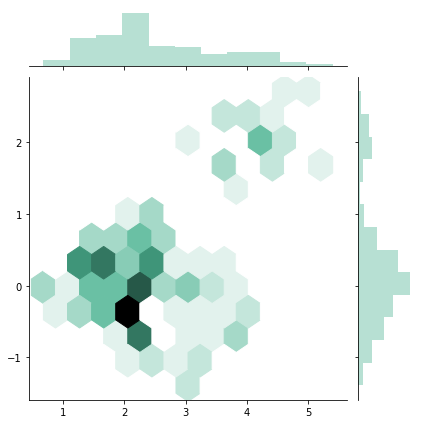

In [129]:
sns.jointplot(df.rmsd.values, df.dist.values, kind="hex", color="#4CB391")

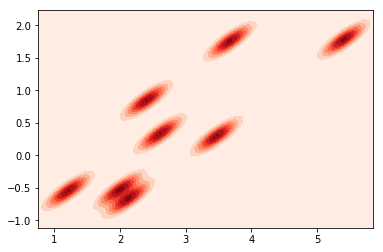

In [130]:
algo = df.sample(frac=0.05)
sns.kdeplot(algo.rmsd.values, algo.dist.values, cmap="Reds", shade=True, bw=.15)

In [131]:
df.groupby('cand').dist.describe().T

cand,0,1
count,128.0000,22.0000
mean,0.2744,0.0970
std,0.9407,0.3153
min,-1.3856,-0.5505
25%,-0.3655,-0.0508
50%,0.0787,0.1128
75%,0.5775,0.3321
max,2.7082,0.5808


In [132]:
27-13

14

In [133]:
32-27

5

In [134]:
40-32

8

In [135]:
58-40

18